# 0 Setup

In [1]:
import os
import data_utils as utils
import data_pipeline as pipeline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# define globals
RAW_DIR = "../data/raw"
PROCESSED_DIR = "../data/processed"
IMG_HEIGHT = IMG_WIDTH = 299
TARGET_HEIGHT = TARGET_WIDTH = 128
BATCH_SIZE = 128

# 1 - Loading data

In [3]:
# define data directories
data_dir = "../data/raw"

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

train_covid_dir = os.path.join(train_dir, "COVID")
train_normal_dir = os.path.join(train_dir, "NORMAL")

val_covid_dir = os.path.join(val_dir, "COVID")
val_normal_dir = os.path.join(val_dir, "NORMAL")

test_covid_dir = os.path.join(test_dir, "COVID")
test_normal_dir = os.path.join(test_dir, "NORMAL")

In [4]:
# initialize image generators with rescaling
train_img_gen = ImageDataGenerator(rescale=1.0 / 255)
val_img_gen = ImageDataGenerator(rescale=1.0 / 255)
test_img_gen = ImageDataGenerator(rescale=1.0 / 255)

# load train data
train_generator = train_img_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
)

# load val data
val_generator = val_img_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
)

# load test data
test_generator = test_img_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# 2 - Data exploration

In [5]:
# get number of images in each directory
num_covid_train = len(os.listdir(train_covid_dir))
num_normal_train = len(os.listdir(train_normal_dir))

num_covid_val = len(os.listdir(val_covid_dir))
num_normal_val = len(os.listdir(val_normal_dir))

num_covid_test = len(os.listdir(test_covid_dir))
num_normal_test = len(os.listdir(test_normal_dir))

print("training data")
print(f"covid: {num_covid_train}")
print(f"normal: {num_normal_train}")

print("\nvalidation data")
print(f"covid: {num_covid_val}")
print(f"normal: {num_normal_val}")

print("\ntest data")
print(f"covid: {num_covid_test}")
print(f"normal: {num_normal_test}")

training data
covid: 800
normal: 800

validation data
covid: 200
normal: 200

test data
covid: 100
normal: 100


In [6]:
# combine paths
all_paths = pipeline.get_image_paths(RAW_DIR)

In [7]:
# check image size
utils.check_image_size(all_paths)

reference image size: (299, 299)
all images have the same size
(checked all 2200 images)


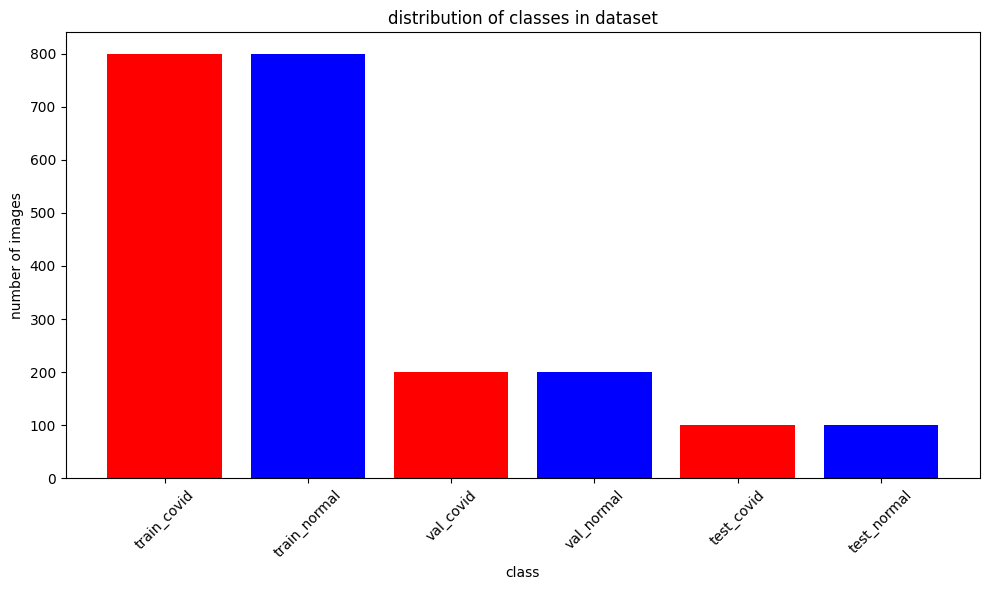

In [8]:
# show distribution of classes
# add previously generated counts to dict
class_counts = {
    "train_covid": num_covid_train,
    "train_normal": num_normal_train,
    "val_covid": num_covid_val,
    "val_normal": num_normal_val,
    "test_covid": num_covid_test,
    "test_normal": num_normal_test,
}

# create bar plot
plt.figure(figsize=(10, 6))
plt.bar(
    class_counts.keys(),
    class_counts.values(),
    color=["red", "blue", "red", "blue", "red", "blue"],
)
plt.xlabel("class")
plt.ylabel("number of images")
plt.title("distribution of classes in dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

covid samples:


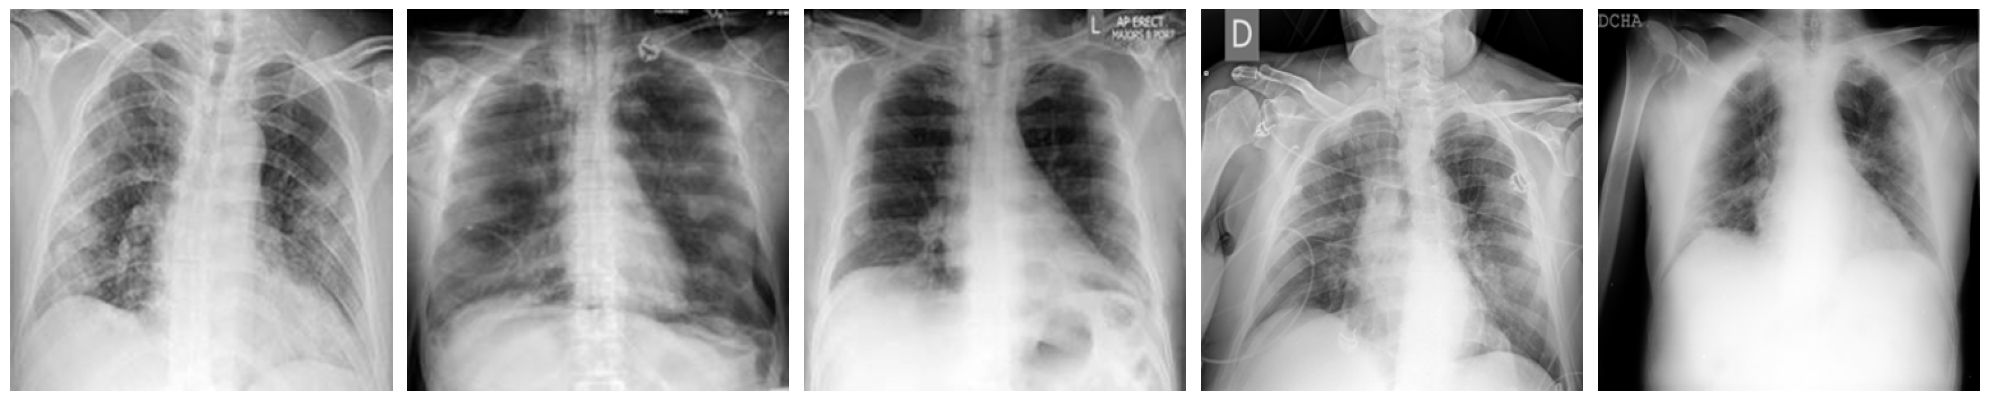

normal samples:


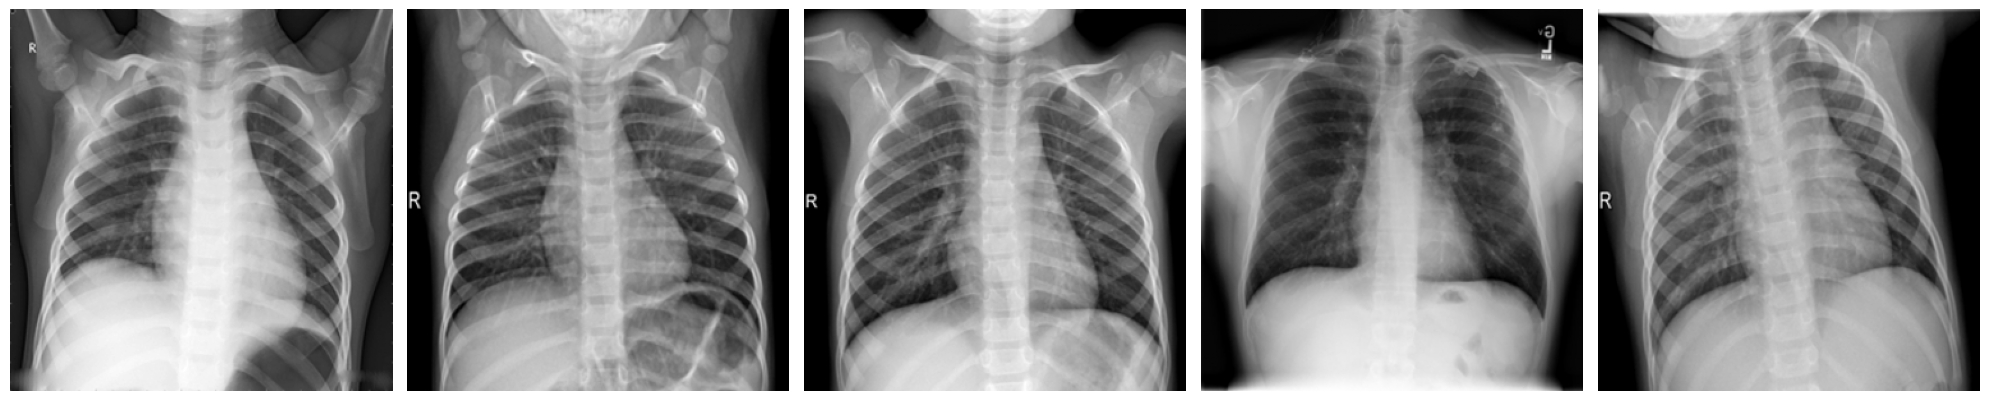

In [9]:
# plot a few samples from each class
train_covid_paths = [path for path in all_paths if path.startswith(train_covid_dir)]
train_normal_paths = [path for path in all_paths if path.startswith(train_normal_dir)]

# sample 5 images from each class
covid_samples = np.random.choice(train_covid_paths, 5, replace=False)
normal_samples = np.random.choice(train_normal_paths, 5, replace=False)

# load images as grayscale
covid_images = [np.array(Image.open(path).convert("L")) for path in covid_samples]
normal_images = [np.array(Image.open(path).convert("L")) for path in normal_samples]

# plot covid images
print("covid samples:")
utils.plotImages(covid_images)

# plot normal images
print("normal samples:")
utils.plotImages(normal_images)

In [10]:
# get other paths
val_covid_paths = [path for path in all_paths if path.startswith(val_covid_dir)]
val_normal_paths = [path for path in all_paths if path.startswith(val_normal_dir)]
test_covid_paths = [path for path in all_paths if path.startswith(test_covid_dir)]
test_normal_paths = [path for path in all_paths if path.startswith(test_normal_dir)]

# calculate stats for each dataset
train_stats = utils.calculate_pixel_stats(train_covid_paths + train_normal_paths)
val_stats = utils.calculate_pixel_stats(val_covid_paths + val_normal_paths)
test_stats = utils.calculate_pixel_stats(test_covid_paths + test_normal_paths)

# display stats in a table
stats_df = pd.DataFrame({"train": train_stats, "val": val_stats, "test": test_stats}).T

print("pixel intensity statistics:")
display(stats_df)

pixel intensity statistics:


,global_mean,global_std,global_min,global_max,per_image_mean_avg,per_image_mean_std,per_image_std_avg,per_image_std_std
train,135.030773,62.210686,0.0,255.0,135.030773,23.773935,55.622600,14.529134
val,137.376634,64.901636,0.0,255.0,137.376634,24.497091,58.744112,12.698197
test,139.270291,66.004260,0.0,255.0,139.270291,25.340164,59.667862,12.417112


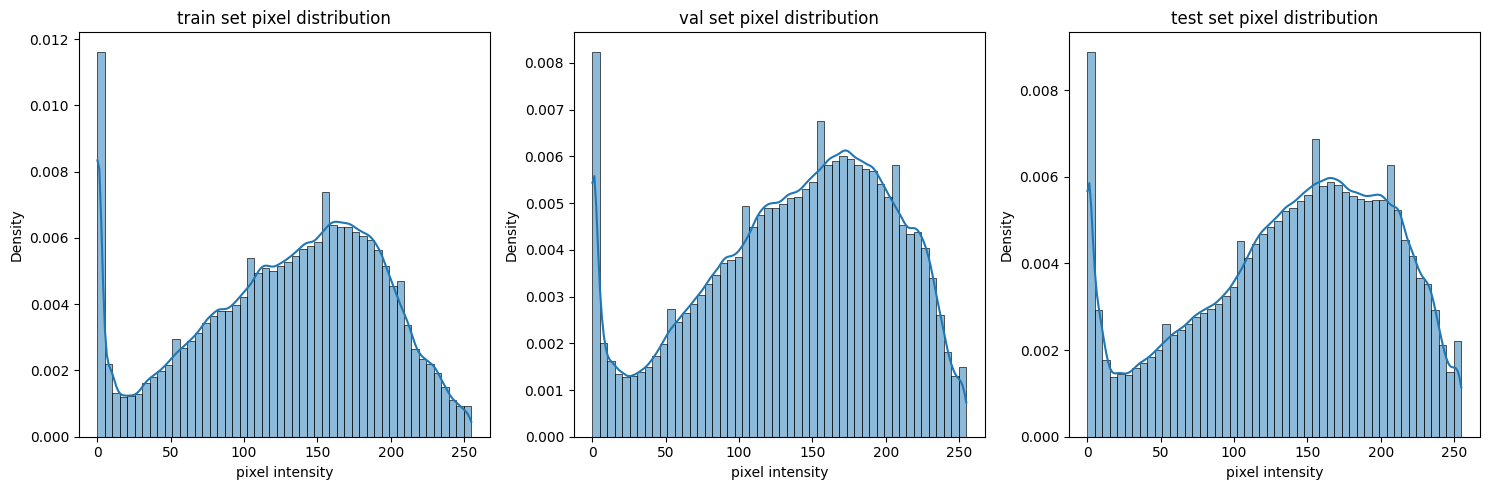

In [11]:
# plot histograms of pixel intensities
plt.figure(figsize=(15, 5))

# sample a subset of images for faster processing
sample_size = min(100, len(train_covid_paths + train_normal_paths))
train_sample = np.random.choice(
    train_covid_paths + train_normal_paths, sample_size, replace=False
)
val_sample = np.random.choice(
    val_covid_paths + val_normal_paths,
    min(sample_size, len(val_covid_paths + val_normal_paths)),
    replace=False,
)
test_sample = np.random.choice(
    test_covid_paths + test_normal_paths,
    min(sample_size, len(test_covid_paths + test_normal_paths)),
    replace=False,
)

# collect pixel values
train_pixels = np.concatenate(
    [np.array(Image.open(p).convert("L")).flatten() for p in train_sample]
)
val_pixels = np.concatenate(
    [np.array(Image.open(p).convert("L")).flatten() for p in val_sample]
)
test_pixels = np.concatenate(
    [np.array(Image.open(p).convert("L")).flatten() for p in test_sample]
)

# plot histograms
plt.subplot(1, 3, 1)
sns.histplot(train_pixels, kde=True, stat="density", bins=50)
plt.title("train set pixel distribution")
plt.xlabel("pixel intensity")

plt.subplot(1, 3, 2)
sns.histplot(val_pixels, kde=True, stat="density", bins=50)
plt.title("val set pixel distribution")
plt.xlabel("pixel intensity")

plt.subplot(1, 3, 3)
sns.histplot(test_pixels, kde=True, stat="density", bins=50)
plt.title("test set pixel distribution")
plt.xlabel("pixel intensity")

plt.tight_layout()
plt.show()

# 3 - Preprocessing

In [12]:
# downsample images
print(f"downsampling {len(all_paths)} images")
processed_paths = []
for path in all_paths:
    input_path = path
    output_path = path.replace(RAW_DIR, PROCESSED_DIR)
    pipeline.downsample_image(input_path, output_path, TARGET_HEIGHT, TARGET_WIDTH)
    processed_paths.append(output_path)

downsampling 2200 images


In [13]:
# calculate mean and standard deviation of downsampled train images
processed_train_paths = [path for path in processed_paths if "train" in path]
print(
    f"calculating mean and standard deviation of {len(processed_train_paths)} train images"
)
mean, std = pipeline.calc_mean_std(processed_train_paths)
print(f"mean: {mean}, std: {std}")

calculating mean and standard deviation of 1600 train images
mean: 135.0429429626465, std: 62.09120035592208


NB: There was of course no need to recalculate the mean and standard deviation here, but the above cells uses the data_pipeline.py file implementation to normalize the images

In the actual pipeline, the images are normalized as part of the data generator, but here we do so manually for illustration purposes

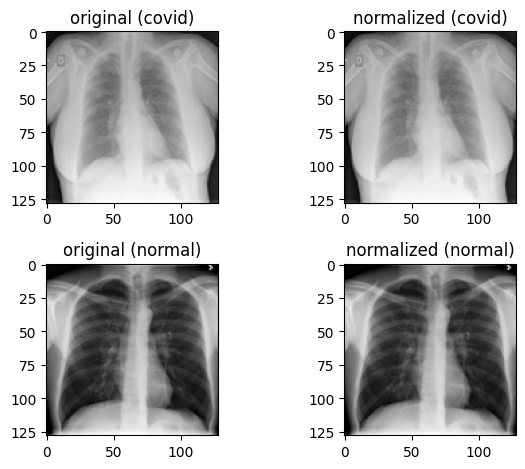

In [19]:
# get paths for each class
processed_val_paths = [path for path in processed_paths if "val" in path]
processed_val_covid_paths = [
    path for path in processed_val_paths if "COVID" in path
]
processed_val_normal_paths = [
    path for path in processed_val_paths if "NORMAL" in path
]

# sample random image from each class
covid_sample = np.random.choice(processed_val_covid_paths, 1, replace=False)
normal_sample = np.random.choice(processed_val_normal_paths, 1, replace=False)

# load images
covid_img = np.array(Image.open(covid_sample[0]).convert("L"))
normal_img = np.array(Image.open(normal_sample[0]).convert("L"))

# normalize images
covid_img_normalized = (covid_img - mean) / (std + 1e-7)
normal_img_normalized = (normal_img - mean) / (std + 1e-7)

# plot
fig, axes = plt.subplots(2, 2)

# show original images
axes[0, 0].imshow(covid_img, cmap="gray")
axes[0, 0].set_title("original (covid)")
axes[1, 0].imshow(normal_img, cmap="gray")
axes[1, 0].set_title("original (normal)")

# show normalized images
axes[0, 1].imshow(np.array(covid_img_normalized), cmap="gray")
axes[0, 1].set_title("normalized (covid)")
axes[1, 1].imshow(np.array(normal_img_normalized), cmap="gray")
axes[1, 1].set_title("normalized (normal)")

plt.tight_layout()
plt.show()

# 4 - Augmentation

NB: In the actual data pipeline, we will augment the images using flow_from_directory, but for now, we can just augment the images and plot them manually

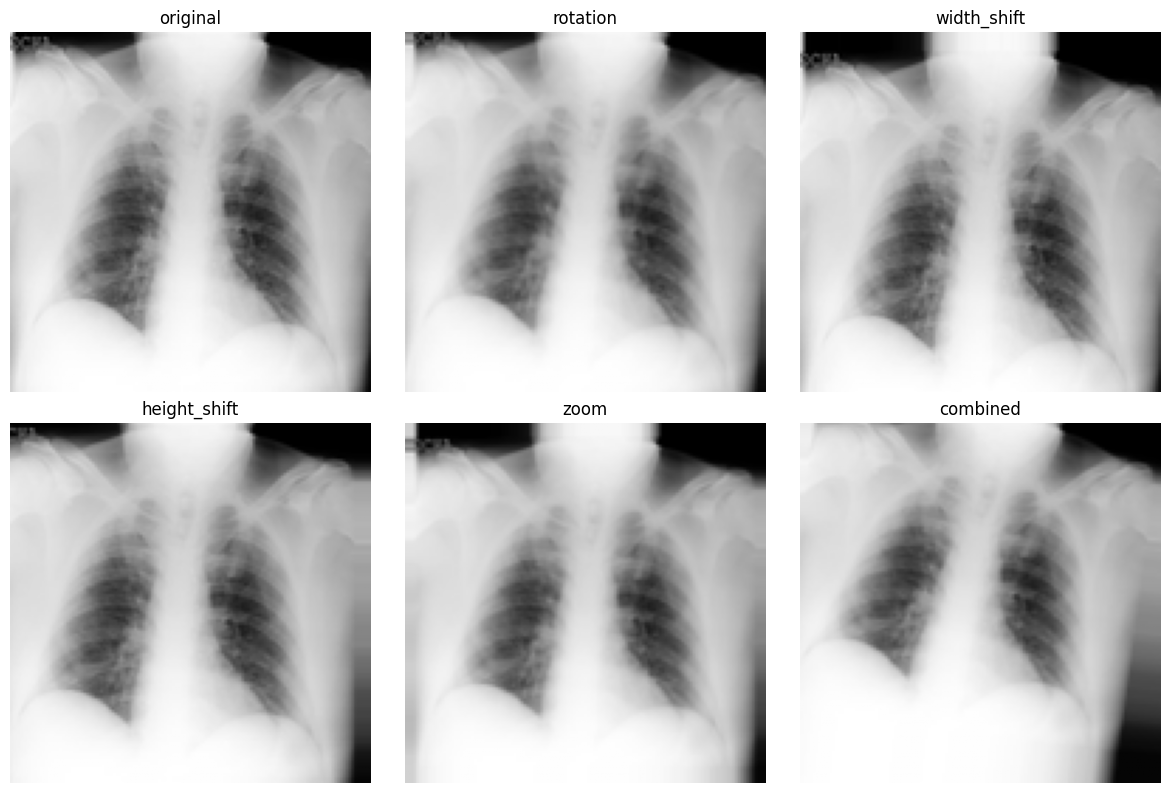

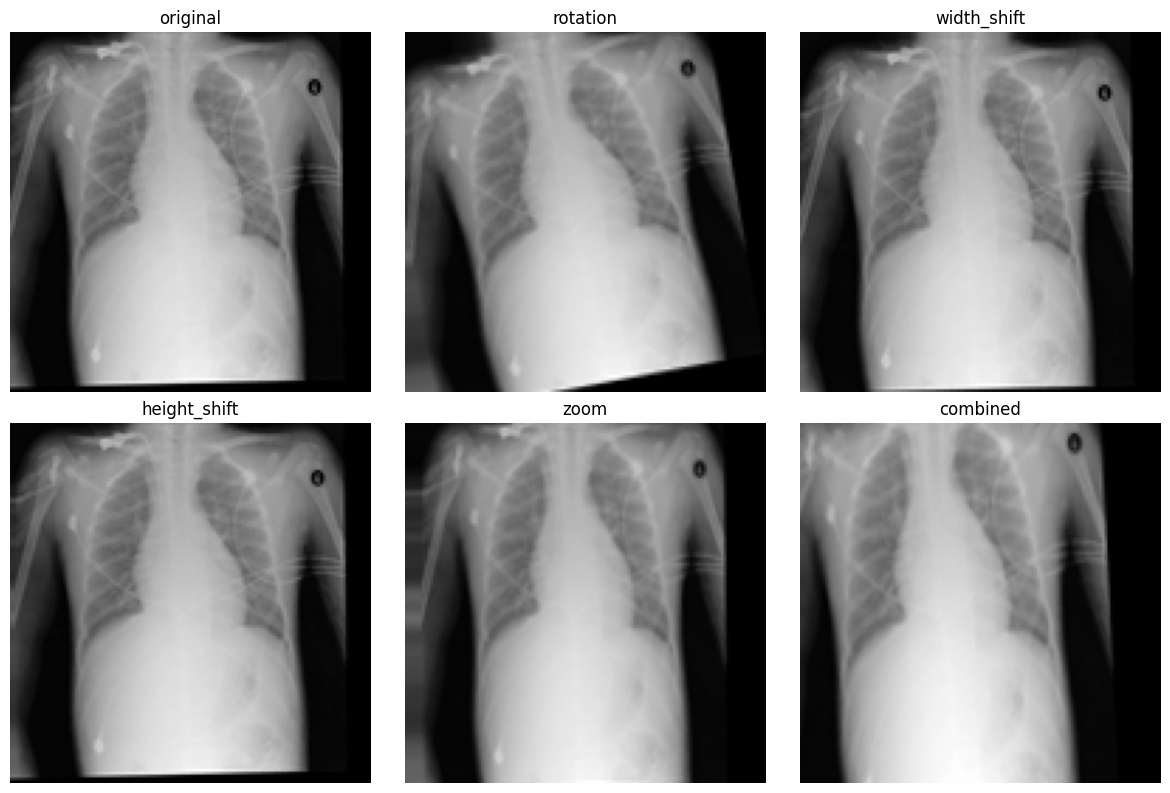

In [15]:
# using same samples as before
utils.visualize_augmentations(covid_img_normalized)
utils.visualize_augmentations(normal_img_normalized)